In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
import os, sys
from scipy.stats import norm, skewnorm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, make_scorer, log_loss, roc_auc_score, brier_score_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gpytorch
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [6]:
proj_dir = 'C:/Users/ady05/Desktop/NU/DANA/NVQI/prob_learning_new/'
workspace = proj_dir + 'XgbDist/OtherModels/VGP-nihss/'
util_dir = proj_dir + 'XgbDist/utils/'
data_dir = proj_dir + 'datasets/'
proc_dir = proj_dir + 'data processing/'

In [7]:
sys.path.insert(0, util_dir)
from data_proc import data_proc_nihss2
from plot_measures import plot_feature_importance

# Data Processing

In [8]:
df_data = pd.read_excel(proc_dir + 'data2.xlsx')
df_num = pd.read_excel(data_dir + 'vargroups_numeric_new.xlsx')
df_cat = pd.read_excel(data_dir + 'vargroups_categorical_new.xlsx')

groupname = 'group 24h'

In [9]:
X_data, y_data, num_names, cat_names = data_proc_nihss2(df_data, df_num, df_cat, groupname)
(X_data.shape, y_data.shape)

((4330, 76), (4330,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.8, random_state=1121218
)

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((3464, 76), (3464,), (866, 76), (866,))

In [11]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 

# Variational Gaussian Process Model

In [12]:
class VariationalGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.LinearMean(input_size=inducing_points.size(1))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + gpytorch.kernels.LinearKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = torch.randn(100, X_train_tensor.shape[1])  
model = VariationalGPModel(inducing_points)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train_tensor.shape[0])

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 

epochs = 100
model.train()
likelihood.train()

for epoch in range(epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() 
        output = model(X_batch)

        loss = -mll(output, y_batch)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    scheduler.step()  
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}')

model.eval()
likelihood.eval()
X_test_tensor = torch.from_numpy(X_test).float()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_tensor))
    mean = predictions.mean.numpy()
    variance = predictions.variance.numpy()

Epoch 1/100, Loss: 102.54095022028143
Epoch 2/100, Loss: 65.82255505648526
Epoch 3/100, Loss: 51.17842483520508
Epoch 4/100, Loss: 44.582978647405454
Epoch 5/100, Loss: 39.09984156868675
Epoch 6/100, Loss: 35.734818025068805
Epoch 7/100, Loss: 32.07476459849965
Epoch 8/100, Loss: 28.740778905695134
Epoch 9/100, Loss: 26.416947035356003
Epoch 10/100, Loss: 24.492139625549317
Epoch 11/100, Loss: 22.470974748784844
Epoch 12/100, Loss: 21.665081249583853
Epoch 13/100, Loss: 20.748112678527832
Epoch 14/100, Loss: 20.139186581698333
Epoch 15/100, Loss: 19.498571482571688
Epoch 16/100, Loss: 19.087305918606845
Epoch 17/100, Loss: 18.643422265486283
Epoch 18/100, Loss: 17.89616446061568
Epoch 19/100, Loss: 17.825861809470435
Epoch 20/100, Loss: 17.153217020901767
Epoch 21/100, Loss: 16.63974489732222
Epoch 22/100, Loss: 16.351458272066985
Epoch 23/100, Loss: 16.4278019991788
Epoch 24/100, Loss: 16.203913428566672
Epoch 25/100, Loss: 15.871138988841663
Epoch 26/100, Loss: 15.850125122070313
Epo

# Measures

In [13]:
def root_mean_squared_error(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_pred, y_test))
def normal_nll(loc, scale, y_test):
    return -norm.logpdf(y_test.flatten(), loc=loc, scale=scale).mean()

In [14]:
print(root_mean_squared_error(mean, y_test))
print(normal_nll(mean, variance **0.5, y_test))

4.303207248817085
8.305909167070869


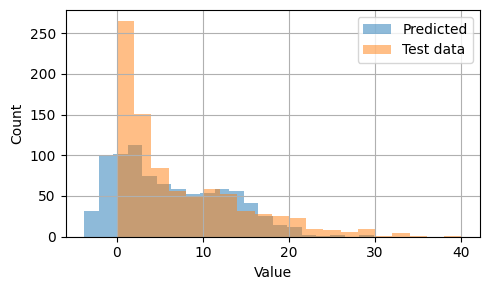

In [15]:
plt.figure(figsize=(5, 3))
plt.hist(mean, bins=20, alpha=0.5, label='Predicted')
plt.hist(y_test,         bins=20, alpha=0.5, label='Test data')
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Count')    
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_residuals(y_true, y_pred, y_err):
    fig, ax = plt.subplots()
    ax.errorbar(
        y_true,
        y_true - y_pred,
        yerr=y_err,
        marker="o",
        linestyle="None",
        c="k",
        markersize=2.5,
        linewidth=0.5,
    )
    ax.axhline(0, c="k", linestyle="--")
    ax.set_xlabel("Actual data")
    ax.set_ylabel("Residuals: Actual - Predicted")
    plt.show()

In [ ]:
plot_residuals(y_test, mean, variance**0.5)

In [ ]:
y_true = np.squeeze(y_test)
y_mean = np.squeeze(mean)
y_sd = np.squeeze(variance ** 0.5)

fit_sd = np.poly1d(np.polyfit(x=y_mean, y=y_sd, deg=5))
y_sd_fit = fit_sd(y_mean)
order = np.argsort(y_mean)
y_lower = y_mean - 2*y_sd_fit
y_upper = y_mean + 2*y_sd_fit

plt.figure(figsize=(8, 5))
plt.plot(y_true[order], 'o', alpha=0.2, label='data')
plt.plot(y_mean[order], color='red', alpha=0.8, label='model $\mu$')
plt.plot(y_lower[order], color='green', alpha=0.15)
plt.plot(y_upper[order], color='green', alpha=0.15)
plt.plot(y_lower[order], color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
plt.plot(y_upper[order], color='green', alpha=0.8)
plt.xlabel('Examples', fontsize=14)
plt.ylabel('NIHSS', fontsize=14)
plt.ylim((-30, 40))
plt.legend(loc='lower right')
plt.grid()
plt.show()